In [3]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)
library(odbc)
library(ggcorrplot)




In [16]:
############################################################################
#####   Package mechkar                                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-01                                       ####
############################################################################

############################################################################
#####   DATA VISUALIZATION                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2014-03-12                                       ####
############################################################################

###########  Functions   ##############################################

###################################################

exploreData <- function(y=NULL, data=data, factorSize=10, dir="report", ...) {

  get_computer_type <- function(){
    # check if current R client is running on PC or on the server
    if (Sys.info()[1] == "Windows") {
      computer.type = "pc"
    } else if (Sys.info()[1] == "Linux") {
      computer.type = "server"
    }
    return(computer.type)
  }

  whatVarType <- function(var) {
    suppressWarnings(if (var=="integer" | var=="numeric") {
      return(1)
    } else if (var=="factor" | var=="character") {
      return(2)
    } else if (var=="Date" | "POSIXct" %in% var[[1]]) {
      return(3)
    } else {
      return(0)
    })
  }

  drawHistogram <- function(imgname=imgname, x=x) {
    d=stats::density(x, kernel = "gaussian",na.rm=TRUE)
    breakstar=(max(x,na.rm=TRUE) -min(x,na.rm=TRUE))/d$bw
    h=graphics::hist(x, breaks=breakstar)
    graphics::plot(h,main="",xlab=imgname)
    yfit<-seq(min(x,na.rm=TRUE),max(x,na.rm=TRUE),length=40)
    ffit<-stats::dnorm(yfit,mean=mean(x,na.rm=T),sd=stats::sd(x,na.rm=T))
    ffit <- ffit*diff(h$mids[1:2])*length(x)
    lines(yfit, ffit, col="blue", lwd=2)
  }

  drawFakeGraph <- function(imgname=imgname) {
    graphics::plot.window(xlim = c(0,0),ylim = c(0,0))
  }

  drawBars <- function(imgname=imgname, x=x) {
    graphics::plot(x)
  }

  drawGraphOne <- function(imgname=imgname, numVar=x, vartype=1) {
    if(vartype==1) {
      drawHistogram(imgname,numVar)
    } else if(vartype==2) {
      drawBars(imgname,numVar)
    } else {
      drawFakeGraph(imgname)
    }
  }

  getContinuousStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    me <- formatC(stats::median(x, na.rm=TRUE))
    q1 <- formatC(stats::quantile(x,1/4, na.rm=TRUE))
    q3 <- formatC(stats::quantile(x,3/4, na.rm=TRUE))
    mn <- formatC(min(x, na.rm=TRUE))
    mx <- formatC(max(x, na.rm=TRUE))
    html <- paste("<div class='Cell' style='align: top;'> <u>Data type</u>: Continuous <p> <u>Data length</u>: ",n ,"/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%)<p> <u>Mean</u>: ", formatC(ma), "\t <u>StdDev</u>: ", formatC(s), "<br><u>Median</u>: ",me,
                  "\t <u>IQR</u>: ", q1, "-", q3, "<br><u>Min</u>: ", mn, "\t <u>Max</u>: ", mx, "</div>")
    return(html)
  }

  getCategortyStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    l <- levels(x)
    s <- summary(x)
    htm <- "<ul>"
    if (length(l) < 5) {
      for (lv in l) {
        htm <- paste(htm, "<li><u>", lv, "</u>: ", s[[lv]], "</li>")
      }
      htm <- paste(htm,"</ul>")
    }
    html <- paste("<div class='Cell'> <u>Data type</u>: Categorical Data <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Number of levels</u>: ", length(l), "<br>", htm, "</div>")
    return(html)
  }

  getDatesStats <- function(x) {
    N <- length(x)
    n <- length(x[which(is.na(x)==FALSE)])
    pct <- formatC(n/N * 100)
    nmiss <- length(x[which(is.na(x)==TRUE)])
    npct <- formatC(nmiss/N *100)
    s <- summary(x)
    html <- paste("<div class='Cell'> <u>Data type</u>: Date <p> <u>Data length</u>: ",n, "/", N, " (", pct, "%) <br> <u>Missing</u>: ",
                  nmiss, " (", npct, "%) <p> <u>Min date</u>: ", min(x, na.rm=T), "<br><u>Max date</u>:",max(x, na.rm=T) , "</div>")
    return(html)
  }

  getStats <- function(numVar=x, vartype=1) {
    if(vartype==1) {
      html <- getContinuousStats(numVar)
    } else if(vartype==2) {
      html <- getCategortyStats(numVar)
    } else if (vartype==3) {
      html <- getDatesStats(numVar)
    } else {
      html <- "<div class='Cell'></div>"
    }
    return(html)
  }

  getOutliers <- function(x) {
    bp <- graphics::boxplot(x,plot=FALSE)
    return(bp$out)
  }

  getOutlierGraph <- function(x) {
    #  mod <- tryCatch({
    outl <- getOutliers(x)
    df <- data.frame(x=x, cl=1)
    if(length(outl)>0) {
      df$cl[which(df$x %in% outl)] <- 2
    }
    pl <- stats::scatter.smooth(df$x,col=df$cl)
    ma <- mean(x, na.rm=TRUE)
    s <- stats::sd(x, na.rm=TRUE)
    graphics::abline(h=ma-(2*s), col="red", lty=2)
    graphics::abline(h=ma+(2*s), col="red", lty=2)
    #  }, error = function(e) {
    #    pl <- drawFakeGraph("none")
    #  })
    return(pl)
  }

  getScatterGraph <- function(df=data,x,y,dtype=1) {
    #  mod <- tryCatch({
    if(dtype==1) {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_smooth(aes(x=data[[x]], y=data[[y]]), method="loess") + xlab(x) + ylab(y)
    } else {
      pl <- ggplot2::ggplot(df) + ggplot2::geom_boxplot(aes(y=data[[x]], color=data[[y]])) + xlab(x) + ylab(y) + labs(color=y)
    }
    return(pl)
  }

  getOutliersHtml <- function(imgname=imgname, x=x, srcdir=srcdir) {
    bp <- getOutliers(x)
    if (length(unique(bp)) > 10) {
      xtrm <- paste("There are ", length(unique(bp)), " outlier values")
    } else if (length(unique(bp)) == 0) {
      xtrm <- "No outlier values found"
    } else {
      xtrm <- paste(formatC(bp), collapse=', ' )
    }
    imgsrc = paste(paste0(srcdir,"/fig/"),imgname, "_2.png",sep="")
    html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='250'><br> <u>Outlier values</u>: <br> ", xtrm, "</div>")
    return(html)
  }
  ################## Prepare for the report ###################
  #report <- paste(mydir,"/report",sep="")
  report <- dir
  if (!file.exists(report)) {
    dir.create(report)
  }
  fig <- paste(report,"/fig",sep="")
  if (!file.exists(fig)) {
    dir.create(fig)
  }
  if (get_computer_type()=="pc") {
    srcdir <- paste0(getwd(),"/",report)
  } else {
    srcdir <- paste0("file_show?path=",getwd(),"/",report)
  }
  # determine which columns are integer
  int_col <- which(sapply(data, is.integer))
  int_col <- c(int_col,(which(sapply(data, is.numeric))))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in int_col) {
    if (length(unique(data[,li])) < factorSize) {
      mi <- c(mi,li)
      if (is.factor(data[,li]) == FALSE) {
        data[,li] <- factor(data[,li])
      }
    }
  }

  str_col <- which(sapply(data, is.character))
  mi <- vector()
  # find only those integers with less than 10 unique values and convert to factor
  for (li in str_col) {
    mi <- c(mi,li)
    data[,li] <- factor(data[,li])
  }

  # create the html report page
  myhtml <- paste(report,"/report.html",sep="")
  cat("<!DOCTYPE html>
      <html>
      <head>
      <title>Data Visualization</title>
      <meta http-equiv='Content-Type' content='text/html; charset=UTF-8' />
      <link rel='stylesheet' href='http://code.jquery.com/mobile/1.4.5/jquery.mobile-1.4.5.min.css'>

      <script src='http://code.jquery.com/jquery-1.10.2.js'></script>
      <script>
      $(document).ready(function(){
      $('.onetoone').hide();
      });

      $(function() {
      $('.origimg').click(function(e) {
      $('#popup_img').attr('src',$(this).attr('src'));
      $('#myContainer').hide();
      var pos = $(document).scrollTop();
      $('#myContainer').css({'top':pos+20,'left':250, 'position':'absolute', 'border':'1px solid black', 'padding':'0px'});
      $('#myContainer').show();
      });
      $('#myContainer').click(function(e) {
      $('#myContainer').hide();
      });

      $('#myform2').submit(function(e) {
      e.preventDefault();
      });

      $('#onetoone').on('click',function() {
      console.log('onetone button - 1');
      $('#onetoone').hide();
      $('#aslist').show();
      // To show only individual rows:
      $('.Row').hide();
      $('.onetoone').show();
      // then we iterate
      var i = $('.Row').length;
      // Then we iterate
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('onetone button - 2');
      });

      $('#aslist').on('click',function() {
      console.log('aslist button - 1');
      $('#onetoone').show();
      $('#aslist').hide();
      $('.onetoone').hide();
      $('.Row').show();
      console.log('aslist button - 2');
      });

      $('#less').on('click',function(){
      console.log('less button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) - 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(1)
      }
      console.log('less button - 2');
      });

      $('#more').on('click',function(){
      console.log('more button - 1');
      var i = $('.Row').length;
      var nxt = parseInt($('#idx').val(),10) + 1;
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('more button - 2');
      });

      $('#idx').on('change', function(){
      console.log('idx changed - 1');
      var i = $('.Row').length;
      var nxt = $('#idx').val();
      if (nxt < i & nxt >0) {
      $('#idx').val(nxt)
      $('.Row').hide();
      $('.Row').eq(0).show();
      $('.Row').eq(nxt).show();
      } else {
      $('#idx').val(i)
      }
      console.log('idx changed - 2');
      });
      });

      </script>

      <style type='text/css'>
      .Table
      {
      display: table;
      }
      .Title
      {
      display: table-caption;
      text-align: center;
      font-weight: bold;
      font-size: larger;
      }
      .Row
      {
      display: table-row;
      }
      .Cell
      {
      display: table-cell;
      border: solid;
      border-width: thin;
      padding-left: 5px;
      padding-right: 5px;
      vertical-align: top;
      font-family: 'arial';
      font-size: 14px;
      }
      </style>

      </head>

      <body>
      <div id='pageone' data-role='main' class='ui-content'>
      ", file = myhtml, sep='\n',append=FALSE)

  html <- paste("<p><p><h1> Data Visualization & Exploration </h1>
                <form>
                <input type='button' id='onetoone' value='Show as Cards'>
                <input type='button' id='aslist' class='onetoone' value='Show as List'>
                </form>
                <p>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # begin table
  alt1 <- ifelse(is.null(y)== TRUE, "", "<div class='Cell Title'> Dependent <br> Variable <br> Distribution </div>")
  html <- paste("<p><p>
                <div class='Table'>
                <div class='Row'>
                <div class='Cell Title'> Variable </div>
                <div class='Cell Title'> Distribution </div>
                <div class='Cell Title'> Descriptive <br> Statistics</div>
                <div class='Cell Title'> Outliers </div>"
                , alt1,
                "</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)

  #### determinate the type of each variable...
  data_types <- sapply(sapply(data, class), whatVarType)

  for(x in names(data)) {
    print(x)
    html <- paste("<div class='Row'><div class='Cell'><b>",x,"</b></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
    #### initialize the first graph
    imgname = paste(fig,"/",x, "_1.png",sep="")
    imgsrc = paste(paste0(srcdir,"/fig/"),x, "_1.png",sep="")
    ### send the data with the type to generate the correct graph..
    grDevices::png(imgname)
    drawGraphOne(x, data[[x]], data_types[x])
    grDevices::dev.off()
    html <- paste0("<div class='Cell'><img class='origimg'  src='",imgsrc,"' height='150' width='150'><br></div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # second, show the statistics
    html <- getStats(data[[x]],data_types[x])
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # third, determine the outliers
    imgname = paste(fig,"/",x, "_2.png",sep="")
    if(data_types[x]==1) {
      grDevices::png(imgname)
      getOutlierGraph(data[[x]])
      grDevices::dev.off()
      html <- getOutliersHtml(x,data[[x]],srcdir)
    } else {
      html <- "<div class='Cell'></div>"
    }
    cat(html, file = myhtml, sep='\n', append=TRUE)

    # fourth, if y is assigned, make a corresponding plot
    if(is.null(y)==FALSE) {
      imgname = paste(fig,"/",x, "_3.png",sep="")
      imgsrc = paste(paste0(srcdir,"/fig/"),x, "_3.png",sep="")
      #print(imgname)
      grDevices::png(imgname)
      ### scatter.smooth(data[[x]] ~ data[[y]])
      #suppressWarnings(getScatterGraph(data,x,y,data_types[y]))
      plot(getScatterGraph(data,x,y,data_types[y]))
      grDevices::dev.off()
      html <- paste0("<div class='Cell'><img class='origimg' src='",imgsrc,"' height='150' width='150'><br></div>")
      cat(html, file = myhtml, sep='\n', append=TRUE)
    }
    html <- paste("</div>")
    cat(html, file = myhtml, sep='\n', append=TRUE)
  }
  html <- paste("</div>")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  # end table
  html <- paste("</div>
                <div data-role='popup' id='myContainer' style='display: none;'>
                <img id='popup_img' src='' />
                </div>
                </div>
                </div>
                </div>
                <p>
                <div class='onetoone'>
                <form id='myform2'>
                <span> <input type='button' id='less' value=' << '> </span>
                <span> <input id='idx' name='idx' value='1'></input></span>
                <span> <input type='button' id='more' value=' >> '> </span>
                </form>
                </div>
                <p>
                </body></html>
                ")
  cat(html, file = myhtml, sep='\n', append=TRUE)
  if(.Platform$OS.type == "unix") {
    system(paste("start /b ", myhtml))
  } else {
    shell(paste("explorer ", gsub("/", "\\\\", myhtml) ), intern=TRUE)
  }
}

###################### END exploreData ###############

############################################################################
#####   TABLE 1                                                         ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-12-19                                       ####
############################################################################

####################  FUNCTIONS  ###########################################
#### Usage:
####   x: character vector with the name of the variables
####   y: the name of the strata variable (optional)
####   rn: character vector with the text we want to replace the variable names
####   data: the dataset to be used
####   miss: include missing statistics: [0=none, 1=only for categorical variables, 2=for all variables]
####   excel: export the table to excel [0=no, 1=yes]
####   excel_file: the name of the excel file we want to save the table (optional)
####
###################

Table1 <- function (x=NULL, y=NULL, rn=NULL, data=NULL, miss=3, catmiss=TRUE, formatted=TRUE, categorize=FALSE,
                    factorVars=NULL, maxcat=10, delzero=TRUE, decimals=1, messages=TRUE, excel=0, excel_file=NULL) {
  ### define sub-functions
  options(warn=-1)
  Del <- NULL
  Pop <- NULL
  n <- NULL
  g1 <- function(var)c(Mean=mean(var,na.rm=TRUE), SD=stats::sd(var,na.rm=TRUE))
  g2 <- function(var)c(Median=stats::median(var,na.rm=TRUE), IQR=stats::quantile(var,c(0.25,0.75),na.rm=TRUE))
  msg <- NULL

  ### function for transforming variables to factors
  setFactors <- function(data=data, factorVars=factorVars, catmiss=catmiss, maxcat=maxcat) {
    #print(factorVars)
    if(is.null(factorVars)==T) {
      aa <- sapply(sapply(data, unique), length)
      factorVars <- names(which(aa <= maxcat))
    }
    #print(factorVars)
    for (v in factorVars) {
      ct <- ifelse( ((is.null(factorVars)==F & (v %in% factorVars)) | (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
      if (ct == 1) {
        data[[v]] <- factor(data[[v]])
        if(catmiss == T & sum(is.na(data[[v]])==T) > 0) {
          data[[v]] <- factor(data[[v]],levels=c(levels(data[[v]]),"Missing"))
          data[[v]][which(is.na(data[[v]])==T)] <- "Missing"
        }
      }
    }
    return(data)
  }
  ### proceed to convert varibles to factors
  if (categorize == T | is.null(factorVars)==F ) {
    data <- setFactors(data, factorVars, catmiss, maxcat)
  }

  getSimpleTable  <- function(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,
                              categorize=categorize,maxcat=maxcat, delzero=delzero) {
    if (is.null(x)==TRUE) { x <- names(data)}
    if (is.null(rn)==TRUE) { rn <- x}
    ln <- length(x)
    pb <- utils::txtProgressBar(min=0,max=ln,style=3)
    msg <- NULL
    ### define the column names
    tableaaaa <- cbind(Del="Del",V1="Variables",V2="Categories",n="n","Population")
    tablebbbb <- cbind(Del="Del",V1="Variables",V2="Categories",n="n",val1="val1",val2="val2",val3="val3")
    tbl1 <- cbind(0,"Individuals","n",n=1, nrow(data))
    tbl2 <- cbind(0,"Individuals","n",n=1, nrow(data),NA,NA)
    tableaaaa <- rbind(tableaaaa,tbl1)
    tablebbbb <- rbind(tablebbbb,tbl2)
    q <- 1
    n <- 1
    ii <- 1
    for (v in x)
    {
      if (v %in% names(data)) {
        ### define if the actual variable has to be treated as numeric or factor
        ct <- ifelse(is.numeric(data[[v]])==T & categorize==T &
                       ((is.null(factorVars)==F & (v %in% factorVars)) |
                          (is.null(factorVars)==T & length(unique(data[[v]])) <= maxcat)),1,0)
        ### treat as numeric
        if (length(unique(data[v]))==0) {
          if (messages==T) {
            #print(paste("The variable",v,"has no data... avoided"))
            msg <- c(msg, paste("The variable",v,"has no data... avoided"))
          }
        } else if (inherits(data[[v]], "Date")==TRUE) {
          if (messages==T) {
            msg <- c(msg, paste("The variable",v,"is a date. Dates are not allowed in Table1... avoided"))
          }
        } else if (is.numeric(data[[v]])==T & ct==0) {
          ## report mean and standard deviation
          t_n <- g1(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),")",sep="")
          tbl1 <- cbind(0,rn[q],"Mean (SD)",n=1, tp)
          tbl2 <- cbind(0,rn[q],"Mean (SD)",n=1,t_n[1],t_n[2],NA)
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report median and Interquartile ranges (25%,75%)
          t_n <- g2(data[[v]])
          tp <- paste(format(round(t_n[1],decimals),nsmall=1,big.mark=",")," (", format(round(t_n[2],decimals),nsmall=1,big.mark=","),"-", format(round(t_n[3],decimals),nsmall=1,big.mark=","), ")",sep="")
          tbl1 <- cbind(0,rn[q],"Median (IQR)",n=2, format(tp,big.mark=","))
          tbl2 <- cbind(0,rn[q],"Median (IQR)",n=2,t_n[1],t_n[2],t_n[3])
          tableaaaa <- rbind(tableaaaa,tbl1)
          tablebbbb <- rbind(tablebbbb,tbl2)
          ## report number and percent of missing
          if (miss >= 1) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=3, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=3, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=3, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=3, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        } else {
          t_n <- table(data[[v]])
          ttotal <- sum(t_n)
          nm <- row.names(t_n)
          for (f in 1:length(nm)) {
            del1 <- ifelse(length(nm)==2 & (nm[f]=="No" | nm[f]=="no" | nm[f]==0 | nm[f]=="0" | nm[f]=="None" | nm[f]=="none"),1,0)
            tp <- t_n[f] / ttotal * 100
            pct <- paste(format(round(t_n[f],decimals),nsmall=0,big.mark=",")," (", format(round(tp,decimals),nsmall=1,big.mark=","), "%)",sep="")
            tbl1 <- cbind(del1,rn[q],nm[f],n=f, pct)             ########### delete rows 0/1 !!!!!!!!!
            tbl2 <- cbind(del1,rn[q],nm[f],n=f, t_n[f], tp, NA)  ########### delete rows 0/1 !!!!!!!!!
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
          if (miss >= 2 & catmiss==F ) {
            datams <- subset(data,is.na(data[[v]])==T)
            if (nrow(datams)>0) {
              data$cnt <- 1
              datams$cnt <- 1
              t_n <- table(data$cnt)
              t_m <- sum(datams$cnt)
              tp <- paste(format(t_m,big.mark=",")," (",format(round((t_m/t_n)*100,decimals),nsmall=1,big.mark=","),"%)",sep="")
              tbl1 <- cbind(0,rn[q],"Missing (%)",n=f, tp)
              tbl2 <- cbind(0,rn[q],"Missing (%)",n=f, t_m, (t_m/t_n)*100, NA)
            } else {
              tbl1 <- cbind(1,rn[q],"Missing (%)",n=f, " -- ")
              tbl2 <- cbind(1,rn[q],"Missing (%)",n=f, NA, NA, NA)
            }
            tableaaaa <- rbind(tableaaaa,tbl1)
            tablebbbb <- rbind(tablebbbb,tbl2)
          }
        }
      } else {
        if (messages==T) {
          msg <- c(msg, paste("The variable",v,"doesn't exists in the dataset... avoiding"))
        }
      }
      q <- q + 1
      utils::setTxtProgressBar(pb,ii)
      ii <- ii + 1
    }
    if(formatted==TRUE) {
      return(tableaaaa)
    } else {
      return(tablebbbb)
    }
    close(pb)
  }

  pvals <- function(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat) {
    ptab <- NULL
    if (is.null(y)==FALSE) {
      if (y %in% names(data)) {
        if (is.null(x)==TRUE) { x <- names(data)}
        if (is.null(rn)==TRUE | length(rn)<2) {rn <- x}
        q <- 1
        ptab <- cbind(V="Variables",pval="pval", n="n")
        for (v in x) {
          if (v %in% names(data)) {
            ct <- ifelse(is.numeric(data[[v]])==T & categorize==T & length(unique(data[[v]])) <= maxcat,1,0)
            if (is.numeric(data[[y]])==T & categorize==T & length(unique(data[[y]])) <= maxcat) {
              data[[y]] <- as.factor(data[[y]])
            } else if (is.numeric(data[[y]])==T) {
              if (messages==T) {
                msg <- c(msg, paste("The variable",y,"is not a factor. Please convert to factor or change the 'categorize' flag to TRUE."))
              }
              pval <- "Please rerun!!!"
            }
            if (is.numeric(data[[v]])==TRUE & length(unique(data[[v]])) > 1 & ct == 0) {
              ### first check for homoscedasticity
              tryCatch({
                if (stats::bartlett.test(data[[v]], data[[y]])[3] >= 0.05) {
                  pval <- round(as.numeric(car::Anova(stats::lm(data[[v]] ~ data[[y]]))[1, 4]), 3)
                } else {
                  pval <- round(as.numeric(car::Anova(stats::lm(data[[v]] ~ data[[y]]), white.adjust = TRUE)[1, 3]), 3)
                }
              }, error = function(e) {
                pval <- "---"
              })
            } else if (length(unique(data[[v]]))==1) {
              pval <- NA
            } else {
              if (min(table(data[[v]],data[[y]])) > 5) {
                pval <- round(as.numeric(stats::chisq.test(data[[v]],data[[y]])$p.val),3)
              } else {
                if(min(table(data[[v]],data[[y]]))==0) {
                  #in cases where there are cells with zero, we use Fisher's exact test
                  tryCatch(
                    pval <- round(as.numeric(stats::fisher.test(data[[v]],data[[y]], workspace=1e9)$p.val),3),
                    error = function(e) {msg <- c(msg,paste0("Unable to calcualte the Fisher test for variables ",v," and ",y))})
                } else {
                  pval <- round(as.numeric(stats::kruskal.test(data[[v]],data[[y]], workspace=1e9)$p.val),3)
                }
              }
            }
            ptab <- rbind(ptab,cbind(V=rn[q],pval=pval,n=2))
          }
          q <- q + 1
        }
      }
    }
    return(ptab)
  }
  ####################### Begin analysis
  ##### if y is null then make a simple table
  tabaaa1 <- getSimpleTable(x=x, rn=rn, data=data, miss=miss, catmiss=catmiss,formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
  tabaaa1 <- tibble::as.tibble(tabaaa1)
  ############################  CHANGE TO 5 !!!!!!!!!!!!!!
  if(length(tabaaa1) > 5) {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop","pop2","pop3")
  } else {
    names(tabaaa1) <- c("Del","V1","V2","n","Pop")
  }
  ##### if y has two levels, then make a compound comparison
  if (is.null(y)==FALSE){
    if (y %in% names(data)) {
      if (is.factor(data[[y]])==F) {
        if (length(levels(factor(data[[y]]))) > 8) {
          if (messages==T) {
            print("The dependent variable has more than 8 levels, table too large!")
          }
        } else if(min(table(data[[y]]))==0) {
          print("The dependent variable has one or more levels with no individuals assigned!")
        } else {
          data[[y]] <- factor(data[[y]])
        }
      }
      if (length(levels(data[[y]])) >= 2) {
        for (lv in levels(data[[y]])) {
          dtsub <- subset(data, data[[y]]==lv)
          tab <- getSimpleTable(x=x, rn=rn, data=dtsub, miss=miss, catmiss=catmiss, formatted=formatted,categorize=categorize,maxcat=maxcat, delzero=delzero)
          tab <- data.frame(tab)
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          if(length(tab) > 5) {
            names(tab) <- c("Del","V1","V2","n",paste0(lv,"_1"),paste0(lv,"_2"),paste0(lv,"_3"))
          } else {
            names(tab) <- c("Del","V1","V2","n",lv)
          }
          ############################  CHANGE TO 5 !!!!!!!!!!!!!!
          tab[1,5] <- lv
          tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, tab))
        }
        # what to do with dichotomous variables? We remove the "Zero" label...
        # clean unnecesary rows
        if (delzero == TRUE) {
          tabaaa1 <- tabaaa1 %>%
            dplyr::filter(Del==0)
        }
        ### calculate the p-value
        ptab <- data.frame(pvals(x=x,y=y,rn=rn,data=data,categorize=categorize,maxcat=maxcat))
        names(ptab) <- c("V1","pval","n")
        tabaaa1 <- suppressMessages(dplyr::left_join(tabaaa1, ptab))

        tabaaa1 <- tabaaa1 %>% dplyr::filter(Pop != " -- ") #%>%
      }
    }
  }
  tabaaa1 <- tabaaa1 %>% dplyr::select(-n) %>% dplyr::select(-Del)
  ##### Join the tables...
  Sys.setenv(JAVA_HOME="")
  if (excel==1) {
    wb <- xlsx::createWorkbook()
    sheet1 <- xlsx::createSheet(wb, sheetName="Table 1")
    xlsx::addDataFrame(tabaaa1,sheet1)
    #### save and close the workbook
    xlsx::saveWorkbook(wb, excel_file)
    return(tabaaa1)
  } else {
    return(tabaaa1)
  }
}

########################## END Table1 ###############

############################################################################
#####   TEST & TRAIN DATASET GENERATION                                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
############################################################################

train_test <- function(data=NULL,train_name=NULL,test_name=NULL,prop=NULL,seed=123,tableone=FALSE)
{
  pval <- NULL
  checkTrainTest <- function(train=NULL,test=NULL) {
    train[["traintest_ind_"]] <- 1
    test[["traintest_ind_"]] <- 2
    df <- rbind(train, test)
    tab <- Table1(data=df, y="traintest_ind_",messages = F)
    vars <- subset(tab, pval < 0.05)$V1
    vars <- setdiff(vars,"traintest_ind_")
    if (length(vars)==0) {
      message("You got a perfectly balanced training and test datasets")
      message(" ")
    } else {
      message("WARNING: The following variables are not balanced between the training and test datasets:")
      for (v in vars) { message(paste("*",v)) }
      message("You can try to change the seed value until you get a balanced partition.")
      message("Alternatively, you can ommit this warning and exclude those variables from your model")
      message(" ")
    }
    return(tab)
  }
  nm <- 1
  ttenv = as.environment(nm)
  ## set the seed to make your partition reproductible
  set.seed(seed)
  smp_size <- floor(prop * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  assign(train_name, data[train_ind, ], envir=ttenv)
  assign(test_name, data[-train_ind, ], envir=ttenv)
  message(paste("Dataset partitioned into:"))
  message(paste(" + Train dataset:", train_name))
  message(paste(" + Test dataset:", test_name))
  if(tableone==TRUE) {
    tab = checkTrainTest(get(train_name),get(test_name))
    return(tab)
  }
}


######################### END train_test ###############


############################################################################
#####   TABLE 2                                                         ####
#####   Description: calculates the Odds/Hazard ratios and their        ####
#####     confidence intervals from a given model
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-03-09                                       ####
#####   Last Modified: 2018-04-16                                       ####
############################################################################

Table2 <- function(mod, rv=NULL,level=0.95, decimals=3) {
  alpha <- 1-level
  msm <- suppressMessages(summary(mod))
  if(rlang::has_name(msm,"coefficients")==T) {
    msm <- msm$coefficients
  } else if(rlang::has_name(msm,"coef")==T) {
    msm <- msm$coef
  }
  if("coxph" %in% class(mod)) {
    exp_coef <- msm[,1]
    dd <- suppressMessages(exp(stats::confint(mod, level=level)))
    dd1 <- round(dd[,1],decimals)
    dd2 <- round(dd[,2],decimals)
    p_value <- round(msm[,ncol(msm)],decimals)
  } else {
    ciz <- stats::qnorm(1-(alpha/2))
    exp_coef <- exp(msm[, 1])
    se_exp_coef <- msm[,2] * exp_coef
    dd1 <- round(exp_coef - ciz * se_exp_coef, decimals)
    dd2 <- round(exp_coef + ciz * se_exp_coef, decimals)
    exp_coef <- round(exp_coef, decimals)
    z<- abs((exp_coef-1)/se_exp_coef)
    p_value <- round(2*(1-stats::pnorm(z)), decimals)
  }
  tb <- data.frame(cbind(Estimate=exp_coef,'CI_lo'=dd1,'CI_hi'=dd2,'p value'=p_value))
  if (is.null(rv)==FALSE) {
    row.names(tb) <- rv
  }
  return(tb)
}

############################################################################
#####   TABLE2 WITH FORESTPLOT                                          ####
#####   Description: Generates a publication ready version of a model   ####
#####      risk table with a forestplot graph inside it                 ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2018-05-17                                       ####
############################################################################
Table2.forestplot <- function(mod, nr=NULL) {
  tryCatch({tbA <- Table2(mod)},
           error=function(cond) {
             message("This model type is not supported !")
             return(NA)
           })
  if(exists("tbA")) {
    ## max value for x axis
    xmax <- max(tbA[,3])
    if(xmax < 5) {
      #axis(1, seq(0,xmax,by=.5), cex.axis=.5)
     rh <- 12
    } else {
      rh <- 18
    }
    colnames(tbA) <- c("coef","ci_low","ci_high","p_value")
    j <- nrow(tbA)
    nm <- row.names(tbA)
    rowseq <- seq(nrow(tbA),1)
    graphics::par(mai=c(1,0,0,0),new=FALSE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    for (i in 1:j) {
      graphics::abline(h=i-0.5,lwd=1, lty=3, col="gray")
    }
    graphics::par(new=TRUE)
    graphics::plot(tbA$coef, rowseq, pch=15,
         xlim=c(-10,rh), ylim=c(0,j+3),
         xlab='', ylab='', yaxt='n', xaxt='n',
         bty='n')
    graphics::axis(1, seq(0,xmax,by=.5), cex.axis=.5)
    graphics::segments(1,-1,1,j, lty=3)
    graphics::segments(tbA$ci_low, rowseq, tbA$ci_hi, rowseq)
    graphics::mtext('Lower risk',1, line=2.5, at=0, cex=.5, font=2)
    graphics::mtext('Higher risk',1.5, line=2.5, at=2, cex=.5, font=2)
    if (is.null(nr)) {
      nr <- data.frame(vars=names(mod$coefficients))
      col2 <- as.character(gsub(x=nr$vars, pattern=paste(names(mod$xlevels),collapse="|"),replacement=" "))
      col3 <- data.frame(vars=as.character(NULL),col3=as.character(NULL))
      for(n in names(mod$xlevels)) {
        col3 <- rbind(col3, cbind(vars=paste(n,levels(mod$data[[n]])[2],sep=""),col3=n))
      }
      nr$col1 <- ifelse(nr$vars %nin% setdiff(names(mod$coefficients),names(mod$data)),as.character(nr$vars),'')
      nr$col2 <- ifelse(nr$vars %nin% col2, col2, " ")
      nr[1,"col1"] <- ifelse(nr[1,"vars"]=="(Intercept)","(Intercept)",nr[1,"vars"])
      nr$col1 <- ifelse(nr$vars %in% col3, col3, nr$col1)
      suppressWarnings(suppressMessages(nr <- dplyr::left_join(nr,col3)))
      nr$col1 <- ifelse(is.na(nr$col3)==T,nr$col1,as.character(nr$col3))
      nr$col1 <- ifelse(grepl(":",nr$vars),nr$vars,nr$col1)
    } else {
      nr <- data.frame(vars=nr)
      if (length(nm)==nrow(nr)) {
        nr <- cbind(nm,nr)
        colnames(nr) <- c("vars","col1","col2")
      } else {
        return("The number of variables in the table of names (nr) you give is not equal to the number of variables in the model.
               Please check the names you entered in the table.")
      }
    }
    ### this part writes the variable titles
    graphics::text(-10,j+2, "Variables", cex=.75, font=2, pos=4)
    graphics::abline(h=j+1, col="gray", lwd=1.5, lty=1)
    graphics::text(-10,rowseq, nr[,2], cex=.75, pos=4, font=3)
    ### and this writes the categories for nominal variables
    graphics::text(-6,rowseq, nr[,3], cex=.75, pos=4)
    graphics::text(-3,j+2, "Odds Ratio (95% CI)", cex=.75, font=2, pos=4)
    t3 <- ifelse(!is.na(tbA$coef),
                 with(tbA, paste(format(coef,nsmall = 3,digits = 3),' (',format(ci_low,nsmall = 3,digits = 3),'-',format(ci_high,nsmall = 3,digits = 3),')',sep='')), '')
    graphics::text(xmax,rowseq, t3, cex=.75, pos=4, bg="lightgreen")
    graphics::text(xmax+5,j+2, "P Value", cex=.75, font=2, pos=4)
    t4 <- ifelse(!tbA$p_value==0, paste0(" ",format(tbA$p_value,nsmall = 3,digits = 3)), '<0.001')
    graphics::text(xmax+5,rowseq, t4, cex=.75, pos=4)
    graphics::box(which = "outer",col="darkgray",lwd=3)
  }
  graphics::par(mai=c(1,1,1,1),new=FALSE)
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR MEANS                        ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
MeanCI <- function(x,round=3) {
  m <- mean(x,na.rm=TRUE)
  s <- stats::sd(x,na.rm=TRUE)
  ci <- 1.96 * (s/sqrt(length(x)))
  CImin <- m - ci
  CImax <- m + ci
  return(c(mean=round(m,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   CALCULATE CONFIDENCE INTERVALS FOR PROPORTIONS                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-24                                       ####
############################################################################
PropCI <- function(x,round=3,multi=100,ref=2) {
  recode <- function(x,ref) {
    y <- x
    if (ref==2) {
      y[which(x==min(x))] <- 0
      y[which(x==max(x))] <- 1
    } else {
      y[which(x==max(x))] <- 0
      y[which(x==min(x))] <- 1
    }
    return(y)
  }
  if (is.factor(x)==TRUE && length(levels(x))==2) {
    p <- levels(x)[ref]
    y <- recode(as.numeric(x),ref)
  } else if (is.numeric(x)==TRUE && length(levels(factor(x)))==2) {
    p <- ifelse(ref==2,max(x),min(x))
    y <- recode(x,ref)
  } else if (length(levels(factor(x)))==2) {
    p <- levels(factor(x))[ref]
    y <- recode(as.numeric(factor(x)),ref)
  } else {
    return("The variable must be dichotomic")
  }
  freq <- (mean(y,na.rm=TRUE))
  CI <- 1.96 * sqrt((freq * (1-freq))/length(y))
  CImin <- (freq - CI)*multi
  CImax <- (freq + CI)*multi
  return(c(var=p,freq=round(freq*multi,round),CImin=round(CImin,round),CImax=round(CImax,round)))
}

############################################################################
#####   GENERATE A TABLE WITH VALIDITY TESTS                            ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-08-17                                       ####
############################################################################

################# Validity Test #########################################
#
#                    Observed
#                              +                  -
#          -----------------------------------------
# Predicted   +    TP                FP        |     PPV
#                                            a                   b         |  e (e1-e2)
#                                                                             |
#                                                             |
#                         -    FN       TN        |     NPV
#                                c        d         |  f (f1-f2)
#                      ----------------------------------------
#
#                        Sensitivity Specificity  |  Prevalence
#                          g (g1-g2)  h (h1-h2)   |  i (i1-i2)
#
#
#       Chi-square
#       Corrected Chi-square
#       Error: (FP+FN)/(TP+FP+FN+TN)
#       Accuracy: (TP+TN)/(TP+FP+FN+TN)
#       Precision: TP/(TP+FP)
#       Recall: TP/(TP+FN)
#
#       Harmonic mean of precision and recall (F1-Score):
#        f1-Score: 2 * (Precision * Recall)/(Precision + Recall)
#
#####################################################################

ValidityTest <- function (a, b, c, d, multi = 100, caption = "Validity of the Model/Screening")
{

  proportionCI <- function(p, n, multi = 100, prob = 0.95, dec = 2) {
    alpha <- ifelse(prob != 0.95,0.01,0.05)
    ci <- Hmisc::binconf(p,n,alpha=alpha,method="wilson")
    pci = paste(round(ci[1] * multi, dec), " (",
                round(ci[2] * multi, dec), "-",
                round(ci[3] * multi, dec), ")",
                sep = "")
    return(pci)
  }

  lr.ci <- function( a,b,c,d, sig.level=0.95 ) {
    ### Positive and negative likelihood ratios with their 95% CI...
    alpha <- 1 - sig.level
    spec <- d/(b+d)
    sens <- a/(a+c)
    lr.pos <- sens/(1 - spec)
    if ( a != 0 & b != 0 ) {
      sigma2 <- (1/a) - (1/(a+c)) + (1/b) - (1/(b+d))
      lower.pos <- lr.pos * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a == 0 & b == 0 ) {
      lower.pos <- 0
      upper.pos <- Inf
    } else if ( a == 0 & b != 0 ) {
      a.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      lower.pos <- 0
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b) - (1/(b+d))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( a != 0 & b == 0 ) {
      b.temp <- (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a) - (1/(a+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- Inf
    } else if ( (a == (a+c)) & (b == (b+d)) ) {
      a.temp <- a - (1/2)
      b.temp <- b - (1/2)
      spec.temp <- d/(b.temp+d)
      sens.temp <- a.temp/(a+c)
      lr.pos.temp <- sens.temp/(1 - spec.temp)
      sigma2 <- (1/a.temp) - (1/(a.temp+c)) + (1/b.temp) - (1/(b.temp+d))
      lower.pos <- lr.pos.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.pos <- lr.pos.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    lr.neg <- (1 - sens)/spec
    if ( c != 0 & d != 0 ) {
      sigma2 <- (1/c) - (1/(a+c)) + (1/d) - (1/(b+d))
      lower.neg <- lr.neg * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c == 0 & d == 0 ) {
      lower.neg<- 0
      upper.neg <- Inf
    } else if ( c == 0 & d != 0 ) {
      c.temp <- (1/2)
      spec.temp <- d/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      lower.neg <- 0
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d) - (1/(b+d))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    } else if ( c != 0 & d == 0 ) {
      d.temp <- (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- Inf
    } else if ( (c == (a+c)) & (d == (b+d)) ) {
      c.temp <- c - (1/2)
      d.temp <- d - (1/2)
      spec.temp <- d.temp/(b+d)
      sens.temp <- a/(a+c.temp)
      lr.neg.temp <- (1 - sens.temp)/spec.temp
      sigma2 <- (1/c.temp) - (1/(a+c)) + (1/d.temp) - (1/(b+d))
      lower.neg <- lr.neg.temp * exp(-stats::qnorm(1-(alpha/2))*sqrt(sigma2))
      upper.neg <- lr.neg.temp * exp(stats::qnorm(1-(alpha/2))*sqrt(sigma2))
    }
    list(
      lr.pos=lr.pos, lower.pos=lower.pos, upper.pos=upper.pos,
      lr.neg=lr.neg, lower.neg=lower.neg, upper.neg=upper.neg
    )
  }

  ppv <- proportionCI(a, a + b, multi)
  npv <- proportionCI(d, c + d, multi)
  sensit <- proportionCI(a, c + a, multi)
  specif <- proportionCI(d, b + d, multi)
  prev <- proportionCI(a + c, (a + b + c + d), multi)
  er <- proportionCI(b + c, (a + b + c + d), multi)
  acc <- proportionCI(a + d, (a + b + c + d), multi)
  prec <- proportionCI(a, (a + b), multi)
  recall <- proportionCI(a, (a + c), multi)
  f1 <- proportionCI(2 * ((a/(a + b)) * (a/(a + c))), ((a/(a + b)) + (a/(a + c))), multi)
  #Odds ratios
  odds <- ((a/c)/(b/d))
  oddsci <- 1.96 * sqrt((1/a)+(1/b)+(1/c)+(1/d))
  oddsratio <- paste(round(odds,2), " (", round(exp(log(odds)-oddsci),2), "-",round(exp(log(odds)+oddsci),2),")",sep="")
  #False positive rate = type I error= 1 - specificity
  fpr <- proportionCI(b, (d + b), multi)
  #False negative rate = type II error= 1 - sensitivity
  fnr <- proportionCI(c, (a + c), multi)
  #Likelihood ratio positive = sensitivity / (1 - specificity)
  # (a/(c+a) / b/(d+b))
  lr <- lr.ci(a,b,c,d,sig.level=0.95)
  plr1 <- paste(round(lr$lr.pos,2), " (", round(lr$lower.pos,2),"-",round(lr$upper.pos,2),")",sep="")
  #Likelihood ratio negative = (1 - sensitivity) / specificity
  # (c/(a+c) / d/(b+d))
  #nlr <- round((c*(b+d))/(d*(a+c)),2)
  #nlr <- ((c*(b+d))/(d*(a+c)))
  nlr1 <-  paste(round(lr$lr.neg,2), " (", round(lr$lower.neg,2),"-",round(lr$upper.neg,2),")",sep="")
  x <- matrix(c(a, b, c, d), byrow = TRUE, 2, 2)
  csq <- tryCatch({
    warning(stats::chisq.test(x))
  }, warning = function(w) {
    message("Using simulated p-value! - ", conditionMessage(w))
    stats::chisq.test(x, simulate.p.value = TRUE)
  })
  xsq <- round(csq$statistic, 2)
  pval <- round(csq$p.value, 2)
  vars <- cbind("", "Observed", "", "")
  vars <- rbind(vars, cbind("", "+", "-", ""))
  vars <- rbind(vars, cbind("Expected", "(TP)", "(FP)", "PPV"))
  vars <- rbind(vars, cbind("+", a, b, ppv))
  vars <- rbind(vars, cbind("", "(FN)", "(TN)", "NPV"))
  vars <- rbind(vars, cbind("-", c, d, npv))
  vars <- rbind(vars, cbind("", "Sensitivity", "Specificity",
                            "Prevalence"))
  vars <- rbind(vars, cbind("", sensit, specif, prev))
  vars <- rbind(vars, cbind("", "", "", ""))
  vars <- rbind(vars, cbind("Chi-square (p-value)", paste(xsq,
                                                          " (", pval, ")", sep = ""), "", ""))
  vars <- rbind(vars, cbind("Error", er, "", ""))
  vars <- rbind(vars, cbind("Accuracy", acc, "",
                            ""))
  vars <- rbind(vars, cbind("Precision", prec, "(Same as PPV)",
                            ""))
  vars <- rbind(vars, cbind("Recall", recall, "(Same as Sensitivity)", ""))
  vars <- rbind(vars, cbind("F1-Score", f1, "(Harmonic mean of",
                            "precision and recall)"))
  vars <- rbind(vars, cbind("Odds ratios", oddsratio, "", ""))
  vars <- rbind(vars, cbind("False positive rate", fpr, "(type I error)", ""))
  vars <- rbind(vars, cbind("False negative rate", fnr, "(type II error)", ""))
  vars <- rbind(vars, cbind("Positive Likelihood ratio", plr1, "", ""))
  vars <- rbind(vars, cbind("Negative Likelihood ratio", nlr1, "", ""))
  return(vars)
}

############################################################################
#####   Model Validity                                                  ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2016-12-01                                       ####
############################################################################
modelValidity <- function (data, model, class, train=FALSE, calib.graph=FALSE)
{
  if ("glm" %in% class(model) | "earth" %in% class(model)) {
    data$pred <- stats::predict(model, newdata = data, type = "response")
  }
  else {
    data$pred <- stats::predict(model, newdata = data, type = "prob")[,2]
  }
  data <- subset(data, is.na(data[["pred"]])==F)
  roc1 <- pROC::roc(data[, class], as.numeric(data[["pred"]]))
  ### GiViTI calibration test
  if(train==FALSE) {
    src="external"
  } else {
    src="internal"
  }
  if(is.factor(data[,class])==T) {data[,class] <- as.numeric(data[,class])-1}
  cb <- givitiR::givitiCalibrationBelt(o=data[,class],e=data[["pred"]],devel=src)
  if(calib.graph==TRUE) {
    graphics::plot(cb, main = "Model calibration", xlab = "Model predicted probability", ylab = "Observed outcome")
  }
  cb <- round(cb$p.value,3)
  ### Hoslem Lemeshow test
  hl <- ResourceSelection::hoslem.test(model$y, stats::fitted(model), g = 10)$p.value
  cm <- table(actual = data[, class], fitted = ifelse(data[["pred"]] >= 0.5, 1, 0))
  mmce <- 1 - (sum(diag(cm))/sum(cm))
  #d <- sjstats::cod(model)$cod
  if (is.factor(data[, class])==T) {data[,class] <- as.numeric(data[, class])-1}
  acc <- ROSE::accuracy.meas(data[,class],data[["pred"]])
  srme <-sqrt((sum((data[, class] - data[["pred"]])^2,na.rm=T))/nrow(data))
  vld <- cbind(auc = roc1$auc, cimin = pROC::ci(roc1)[1], cimax = pROC::ci(roc1)[3],
               SRME = srme,
               precision = acc$precision, recall = acc$recall, fscore = acc$F,
               NPV =  InformationValue::npv(data[, class], data[["pred"]]), mmce = mmce, Hosmer_Lemeshow = hl,GiViTI_calibration=cb)
  vld <- round(vld, 3)
  return(vld)
}

############################################################################
#####   Model Cutoffs                                                   ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-07-09                                       ####
############################################################################
getModelCutoffs <- function(pred, obs, div=10) {
  #pred <- dc <- NULL
  modValidity <- function(a,b,c,d,cutoff) {
    ppv <- (a/(a+b))*100
    npv <- (d/(c + d))*100
    sensit <- (a/(c + a))*100
    specif <- (d/(b + d))*100
    prev <- ((a + c)/(a + b + c + d))*100
    er <- ((b + c)/(a + b + c + d))*100
    acc <- ((a + d)/(a + b + c + d))*100
    prec <- (a/(a + b))*100
    recall <- (a/(a + c))*100
    lift <- ppv/prev
    f1 <- ((2 * ((a/(a + b)) * (a/(a + c))))/((a/(a + b)) + (a/(a + c))))*100
    return(cbind(cutoff=cutoff,TP=a,FP=b,FN=c,TN=d,sensitivity=sensit,specificity=specif,PPV=ppv,NPV=npv,accuracy=acc,error=er,prevalence=prev,lift=lift,precision=prec,recall=recall,F1_score=f1))
  }
  getQuintiles <- function(x,div=div) {
    cut(x, breaks=c(stats::quantile(x, probs = seq(0, 1, by = 1/div),na.rm = T)),
        include.lowest=TRUE)
  }
  dc <- getQuintiles(pred,div=div)
  fl <- unique(levels(dc))
  res <- NULL
  for (i in 1:length(fl)) {
    # get the selected cutoff
    idx <- dc %nin% fl[i]
    pred1 <- rep(0,length(pred))
    pred1[idx] <- 1
    ####
    mn <- min(pred[dc==fl[i]])
    #tab1 <- table(obs,pred=ifelse(data[["pred"]] > mn,1,0))
    tab1 <- table(pred1,obs)
    res <- rbind(res, round(modValidity(tab1[4],tab1[3],tab1[2],tab1[1],mn),3))
  }
  return(res)
}

############################################################################
#####   AGE ADJUSTED RATES                                              ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
############################################################################
age_adjusted <- function(dataset,outcome,age,agemin=0,agemax=130,source="who",alpha=0.05) {
  #utils::globalVariables(c("weight","n","weighted_pct","outcome1","wght","adj","res","pop"))
  weight <- n <- outcm1 <- wght <- pop <- adj <- res <- NULL
  ###### generate tables
  age_group <- c("0-4","5-9","10-14","15-19","20-24","25-29","30-34",
                 "35-39","40-44","45-49","50-54","55-59","60-64",
                 "65-69","70-74","75-79","80-84","85-89","90-94",
                 "95-99","100+")

  age_min <- seq(0,100,5)
  age_max <- c(seq(4,99,5),130)
  who <- c(8860,8690,8600,8470,8220,7930,7610,7150,6590,6040,5370,
           4550,3720,2960,2210,1520,910,440,150,40,5)
  euro <- c(5000,5500,5500,5500,6000,6000,6500,7000,7000,7000,
           7000,6500,6000,5500,5000,4000,2500,1500,800,180,20)
  us <- c(20201362,20348657,20677194,22040343,21585999,21101849,
          19962099,20179642,20890964,22708591,22298125,19664805,
          16817924,12435263,9278166,7317795,5743327,3620459,
          1448366,371244,53364)
  age.adjust <- tibble::tibble(age_group, age_min, age_max, who, euro, us)
  weighted_pct <- function(dataset,outcome,age,source,agemin,agemax) {
    weighting <- age.adjust %>%
      dplyr::select_(~age_group, ~age_min, ~age_max, source)
    weighting <- weighting %>% dplyr::filter_(~age_min >= agemin, ~age_max <= agemax)
    ages <- tibble::tibble(age=seq(0,120,1))
    ages <- ages %>% dplyr::mutate(age_min = ifelse((age/10)-floor(age/10) < 0.5, floor(age/10)*10, (floor(age/10)*10)+5),
                            age_max = ifelse((age/10)-floor(age/10) < 0.5, (floor(age/10)*10)+4, (floor(age/10)*10)+9))
    ages <- ages %>% dplyr::mutate(age_min=replace(age_min, age_min > 100,100),
                            age_max=replace(age_max, age_max > 100, 130))
    ##### take the correct weighting
    tot <- sum(weighting[,source])
    weighting <- weighting %>%
      dplyr::mutate_(weight=source) %>%
      dplyr::mutate(weight=(weight/tot))
    weighting <- suppressMessages(dplyr::inner_join(weighting, ages))
    dataset[,"outcome"] <- ifelse(dataset[,outcome]==1,1,0)
    ### correct for age names to be able to do the joint
    dataset[,"age"] <- dataset[,age]
    unw <- (table(dataset[,"outcome"])/nrow(dataset))[2]
    d1 <- suppressMessages(dplyr::inner_join(dataset, weighting))
    #### we have yet calculated the weight.. use it!!!!
    d1 <- d1 %>%
      dplyr::select(age_group, weight, outcome)#, tot)
    d2 <- d1 %>%
      dplyr::group_by(age_group) %>%
      dplyr::select(age_group, weight, outcome) %>%
      dplyr::summarise(outcm1=sum(outcome),
                wght=max(weight),
                pop=n()) %>%
      dplyr::select(outcm1,wght,pop)
    d2$adj <- (d2$wght * d2$outcm1)/d2$pop
    wgt <- d2 %>%
      dplyr::summarise(res=sum(adj)) %>%
      dplyr::select(res) %>%
      as.numeric()
    return(cbind(unw,wgt))
  }
  t1 <- nrow(dataset)
  evnt1 <- table(dataset[,outcome])[2]
  res1 <- round(weighted_pct(dataset=dataset,outcome=outcome,age=age,source,agemin,agemax),5)
  res1 <- round(res1,4)
  unw1 <- round(Hmisc::binconf((t1*res1[1]),t1,alpha=alpha),4)
  wgt1 <- round(Hmisc::binconf((t1*res1[2]),t1,alpha=alpha),4)
  g1 <- list(Outcome=outcome,Population=t1,Events=evnt1,
             crude=list(rate=res1[1]*100.0,
                        CImin=unw1[2]*100.0,
                        CImax=unw1[3]*100.0),
             weighted=list(rate=res1[2]*100.0,
                           CImin=wgt1[2]*100.0,
                           CImax=wgt1[3]*100.0)
             )
  #g1 <- data.frame(Outcome=outcome,Population=t1,Events=evnt1,CrudeRate=res1[1]*100.0,
  #                 'CR[CImin]'=unw1[2]*100.0,'CR[CImax]'=unw1[3]*100.0,
  #                 WeightedRate=res1[2]*100.0,'WR0[CImin]'=wgt1[2]*100.0,
  #                 'WR[CImax]'=wgt1[3]*100.0)
  return(g1)
}

############################################################################
#####   GET THE MISSINGNESS OF A DATASET                                ####
#####   Author: Tomas Karpati M.D.                                      ####
#####   Creation date: 2017-05-07                                       ####
############################################################################
### search for the number & % of missinf
### then count the number of rows with complete data
getMissingness <- function(data, getRows=FALSE) {
  #utils::globalVariables(c("desc","na_count","na_cnt","rn","pred","dc"))
  desc <- na_count <- na_cnt <- rn <- pred <- dc <- NULL
  l <- nrow(data)
  vn <- names(data)
  ### copy the dataset and replace the NAs by 1 else 0
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x) ))
  for(n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]])==T,1,0)
    cnt <- rbind(cnt, data.frame(n,sum(nadf[[n]])))
  }
  names(cnt) <- c("var","na_count")
  cnt$rate <- round((cnt$na_count / nrow(nadf))*100,1)
  ### now sum by column
  nadf$na_cnt <- 0
  nadf$na_cnt <- rowSums(nadf)
  ### order descending the count of mossings and leave only those with missings
  cnt <- cnt %>%
    dplyr::arrange(desc(na_count)) %>%
    dplyr::filter(na_count>0)
  #totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::tally()
  totmiss <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::summarise(n=n())
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss), " (",as.character(round(totmiss/nrow(data)*100,1)),"%)" ," complete rows. Original data has ",nrow(data)," rows.",sep=""))
  ### check id needs to return the row indexes
  if(getRows==TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na_cnt==0) %>% dplyr::select(rn)
  }
  print(list(head(cnt,n=10), msg))
  return(list(missingness=cnt, message=msg, rows=idx$rn))
}



In [6]:
con <-dbConnect(odbc(),
                Driver="SQL Server", 
                Server= "DESKTOP-F1Q7Q52\\SQLEXPRESS",
                Database="BoxOffice",
                Trusted_connection = "True")

In [7]:
movies_ff <- dbReadTable(con,"movies_ff_v")


In [9]:
save(movies_ff,file="C:/Users/elile/Desktop/DS10/GITT/data/BoxOffice_ff.RData")

In [11]:
load ("C:/Users/elile/Desktop/DS10/GITT/data/BoxOffice_ff.RData")

In [14]:
exploreData<-movies_ff


In [17]:
exploreData (movies_ff)

ERROR: Error in lapply(X = X, FUN = FUN, ...): promise already under evaluation: recursive default argument reference or earlier problems?


In [31]:
BoxOffice<-movies_ff

In [32]:
summary(BoxOffice)

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
 release_date          runtime      runtime_cat           revenue         
 Length:7375        Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 Class :character   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Mode  :character   Median :104.0   Mode  :character   Median :1.693e+07  
                    Mean   :107.7                      Mean   :6.688e+07  
                    3rd Qu.:118.0        

In [30]:

if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}
if(!require(pastecs)) {install.packages("pastecs");require(ggExtra)}
if(!require(ggcorrplot)) {install.packages("ggcorrplot");require(ggcorrplot)}

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"NAs introduced by coercion"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in plot.window(...): need finite 'ylim' values


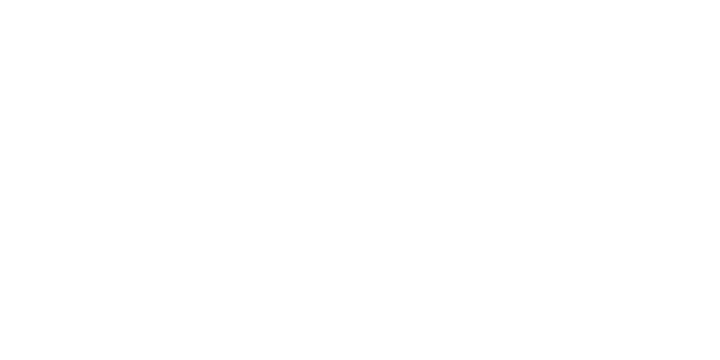

In [36]:
options(repr.plot.width = 6, repr.plot.height = 3)
plot(BoxOffice$runtime_cat)

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."

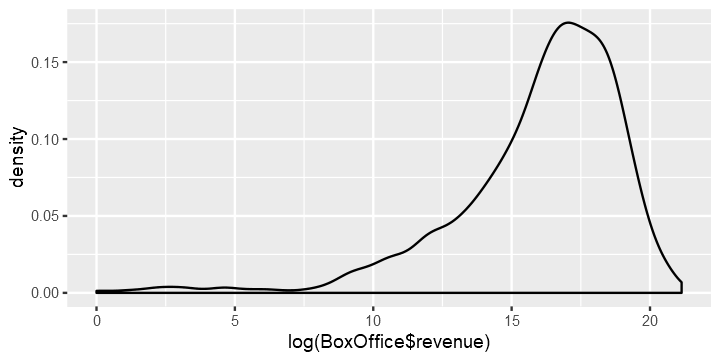

In [38]:
ggplot(data=BoxOffice) +
    geom_density(aes(log(BoxOffice$revenue)))

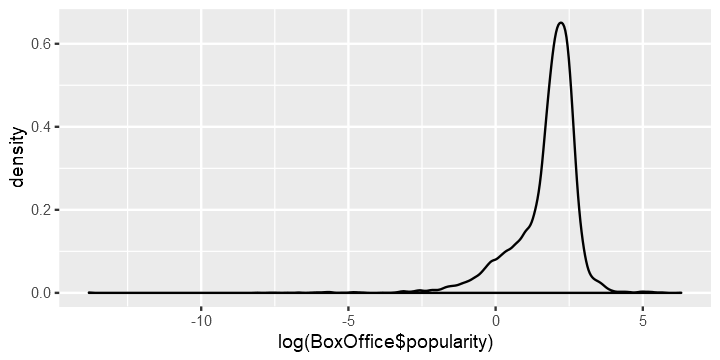

In [42]:
ggplot(data=BoxOffice) +
    geom_density(aes(log(BoxOffice$popularity)))

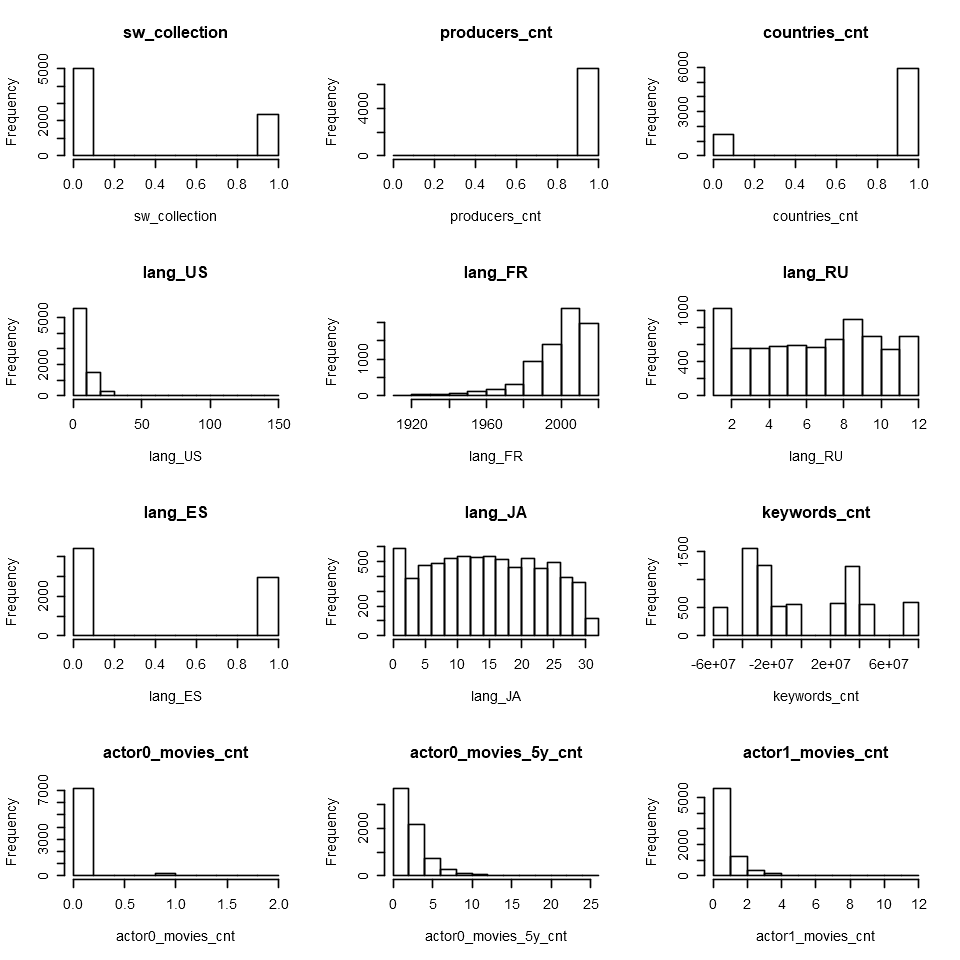

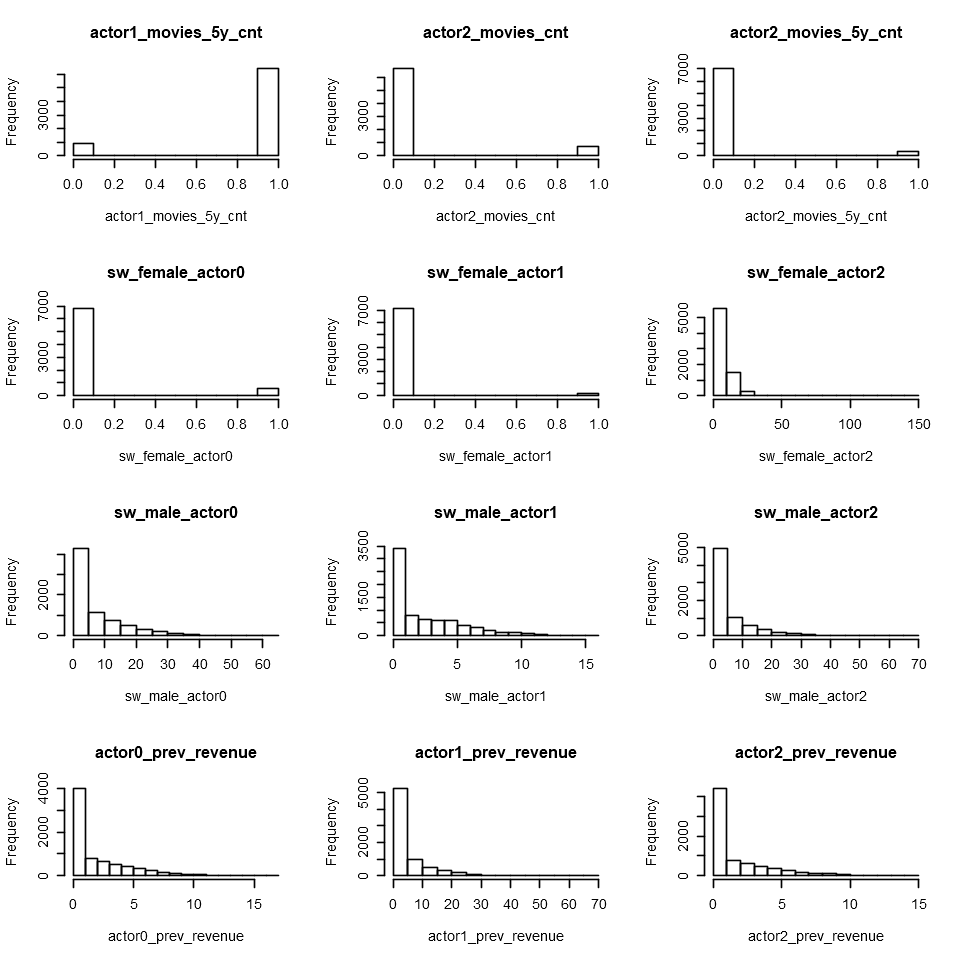

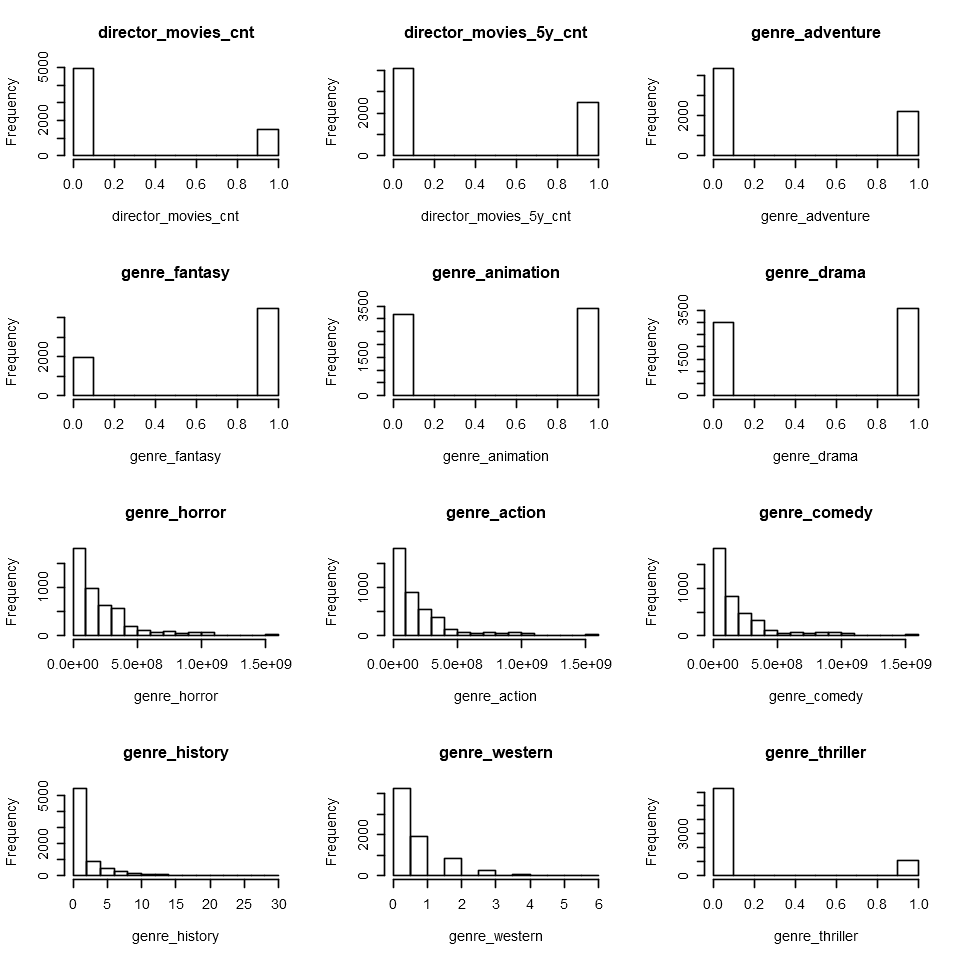

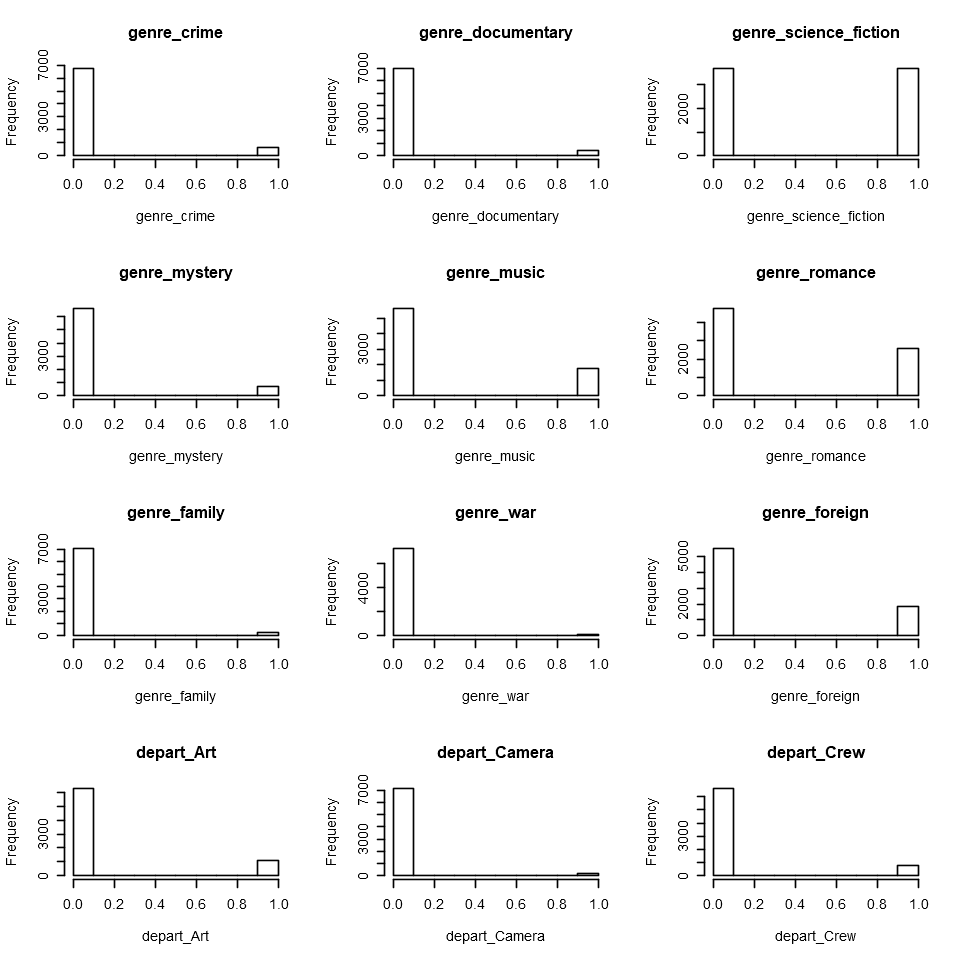

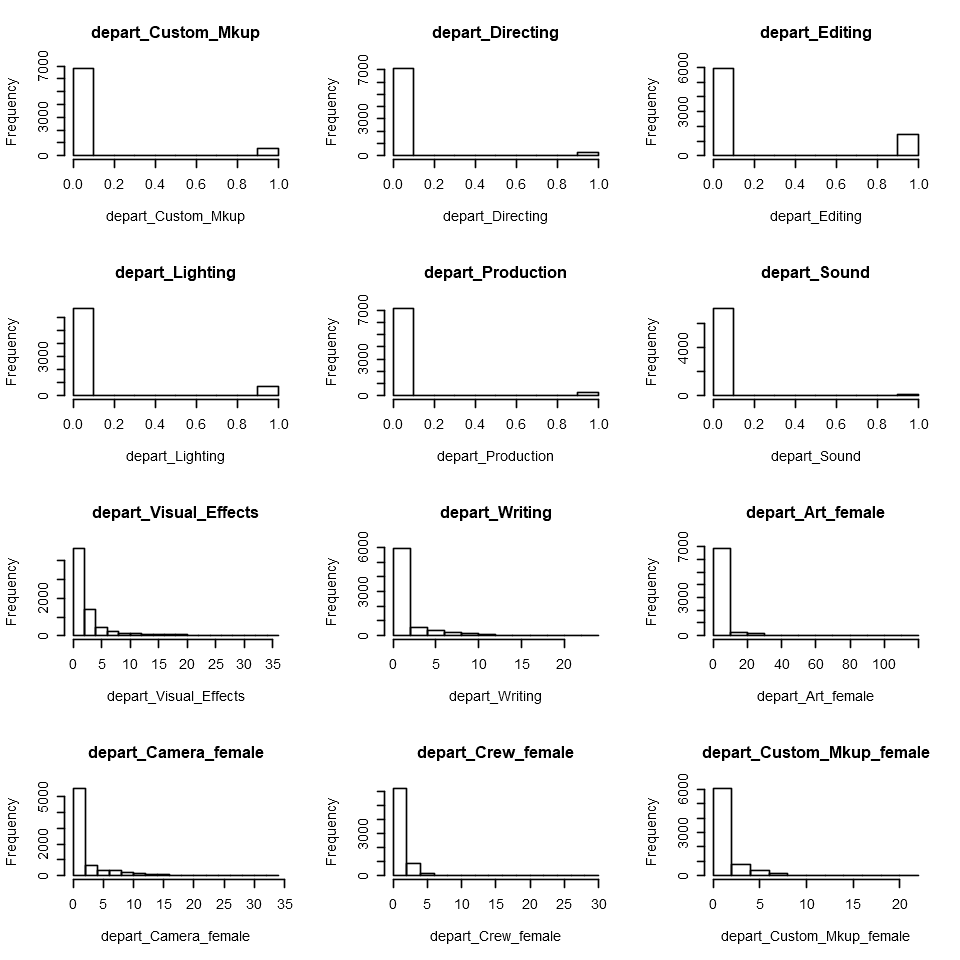

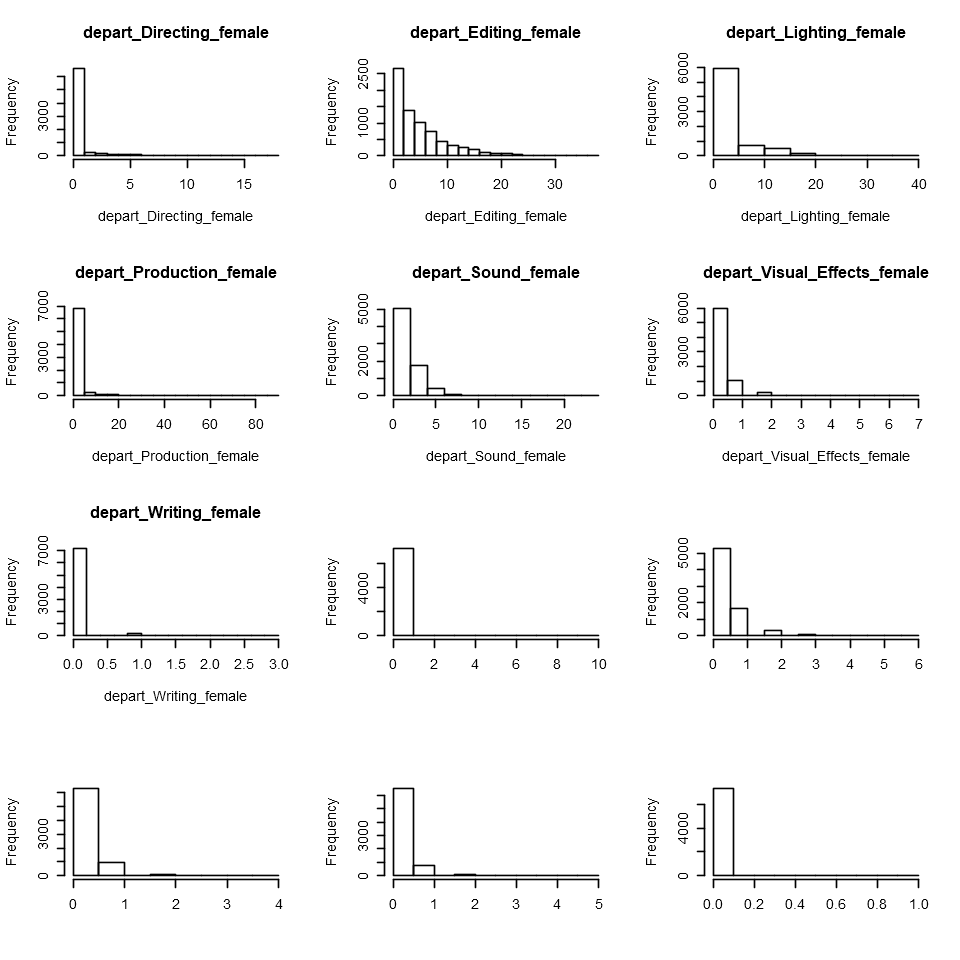

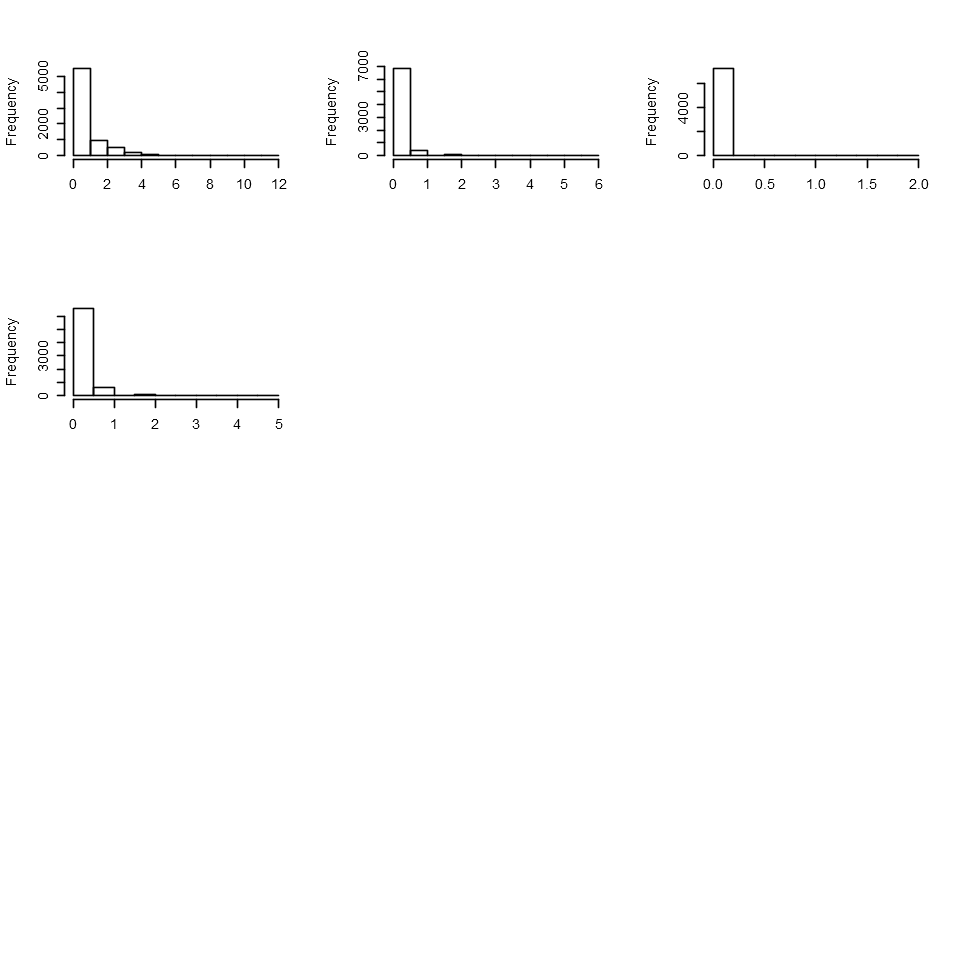

In [74]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
nm <- names(BoxOffice[,10:85])
for(i in 10:85){
    x<-BoxOffice[,i]
    hist (x,xlab=nm[i],main=nm[i])
    }


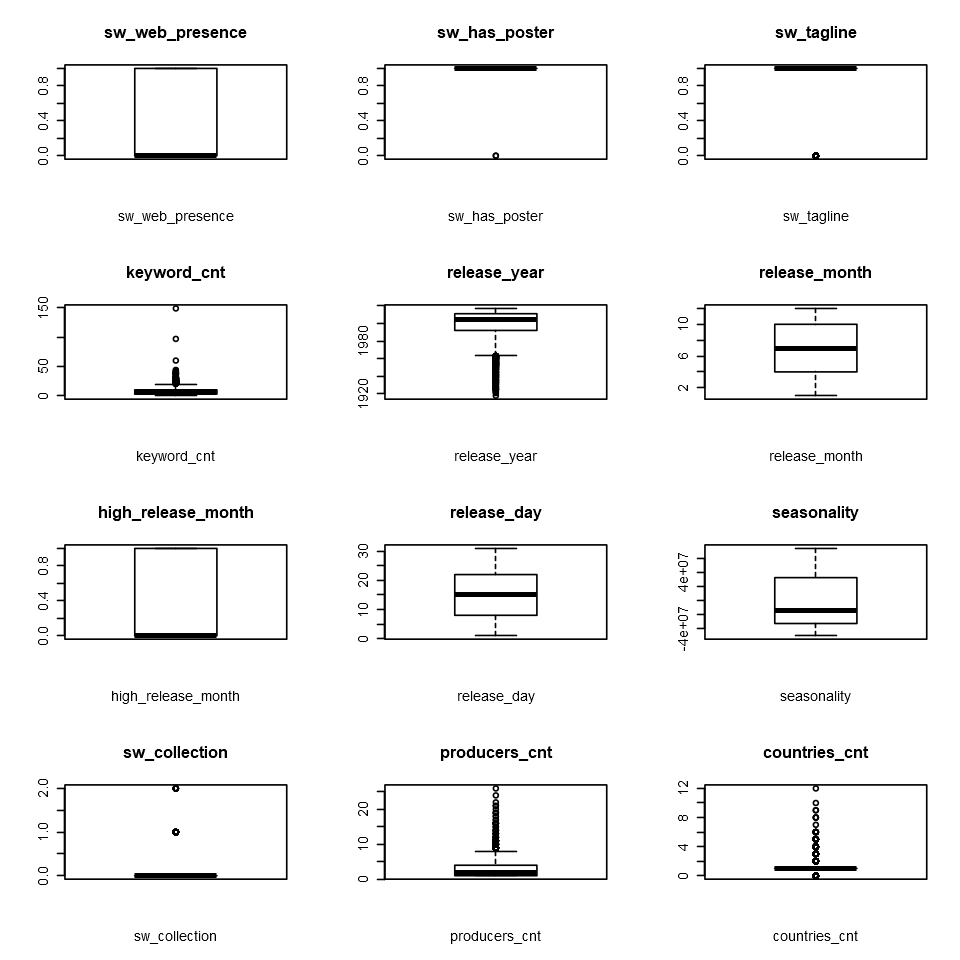

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"

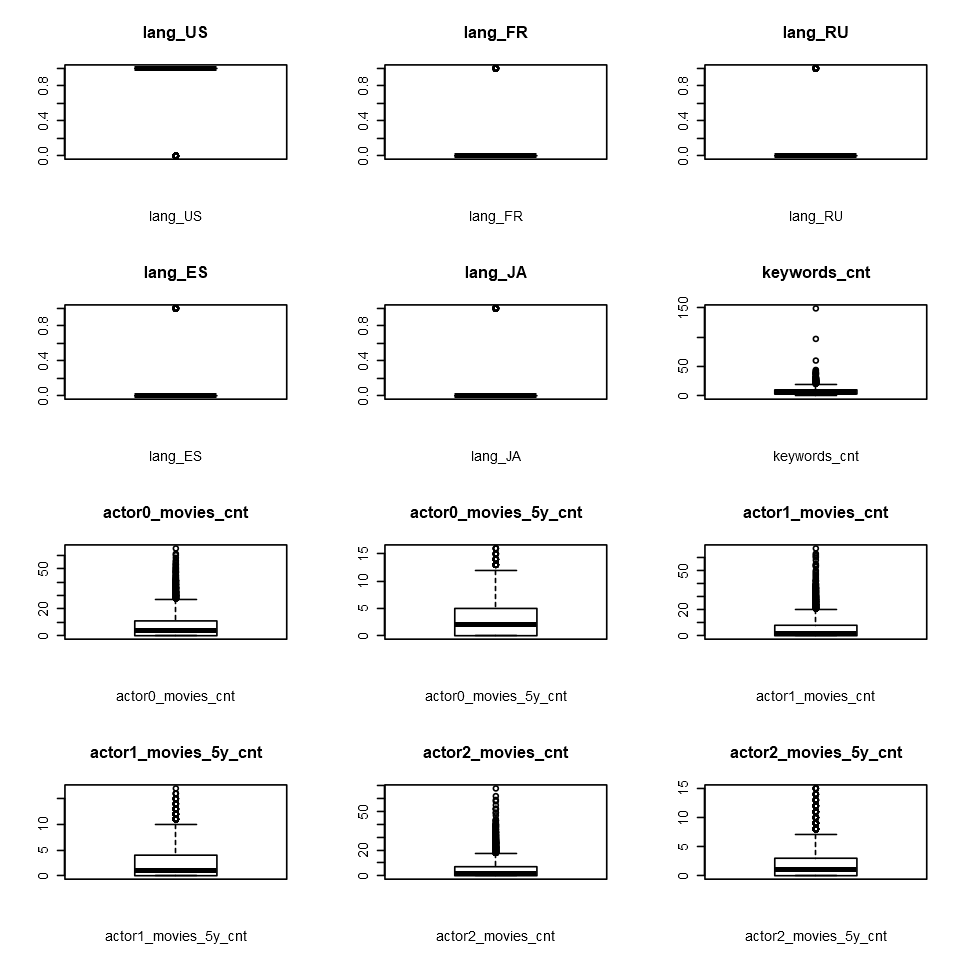

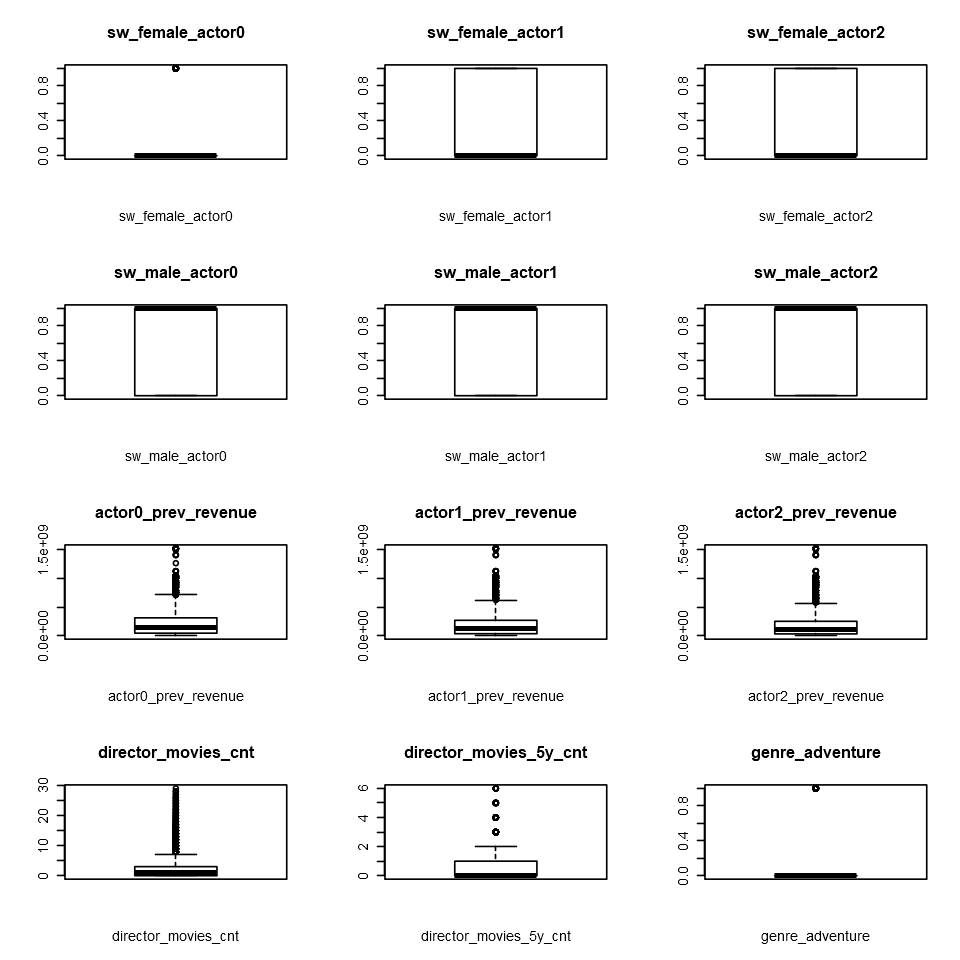

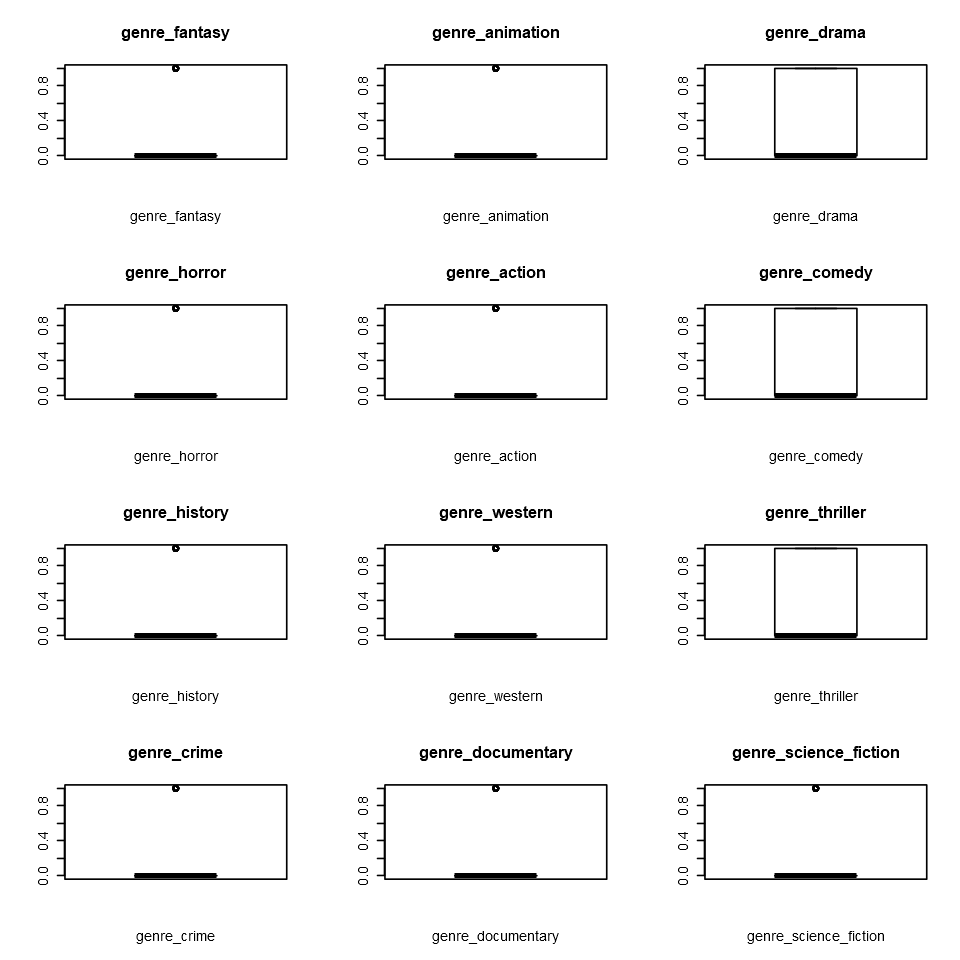

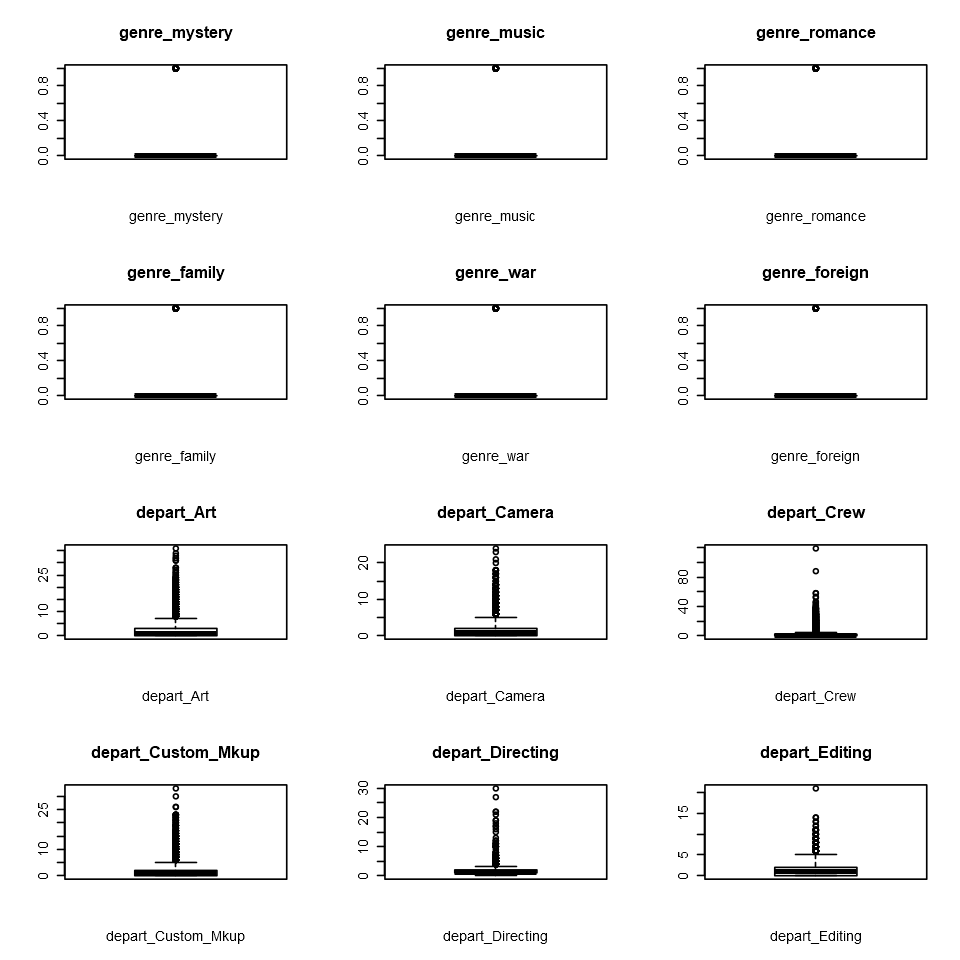

[1] "movie_id"                     "budget"                      
 [3] "original_language"            "popularity"                  
 [5] "release_date"                 "runtime"                     
 [7] "runtime_cat"                  "revenue"                     
 [9] "sw_lang_en"                   "sw_web_presence"             
[11] "sw_has_poster"                "sw_tagline"                  
[13] "keyword_cnt"                  "release_year"                
[15] "release_month"                "high_release_month"          
[17] "release_day"                  "seasonality"                 
[19] "sw_collection"                "producers_cnt"               
[21] "countries_cnt"                "lang_US"                     
[23] "lang_FR"                      "lang_RU"                     
[25] "lang_ES"                      "lang_JA"                     
[27] "keywords_cnt"                 "actor0_movies_cnt"           
[29] "actor0_movies_5y_cnt"         "actor1_movies_cnt"           
[31] "actor1_movies_5y_cnt"         "actor2_movies_cnt"           
[33] "actor2_movies_5y_cnt"         "sw_female_actor0"            
[35] "sw_female_actor1"             "sw_female_actor2"            
[37] "sw_male_actor0"               "sw_male_actor1"              
[39] "sw_male_actor2"               "actor0_prev_revenue"         
[41] "actor1_prev_revenue"          "actor2_prev_revenue"         
[43] "director_movies_cnt"          "director_movies_5y_cnt"      
[45] "genre_adventure"              "genre_fantasy"               
[47] "genre_animation"              "genre_drama"                 
[49] "genre_horror"                 "genre_action"                
[51] "genre_comedy"                 "genre_history"               
[53] "genre_western"                "genre_thriller"              
[55] "genre_crime"                  "genre_documentary"           
[57] "genre_science_fiction"        "genre_mystery"               
[59] "genre_music"                  "genre_romance"               
[61] "genre_family"                 "genre_war"                   
[63] "genre_foreign"                "depart_Art"                  
[65] "depart_Camera"                "depart_Crew"                 
[67] "depart_Custom_Mkup"           "depart_Directing"            
[69] "depart_Editing"               "depart_Lighting"             
[71] "depart_Production"            "depart_Sound"                
[73] "depart_Visual_Effects"        "depart_Writing"              
[75] "depart_Art_female"            "depart_Camera_female"        
[77] "depart_Crew_female"           "depart_Custom_Mkup_female"   
[79] "depart_Directing_female"      "depart_Editing_female"       
[81] "depart_Lighting_female"       "depart_Production_female"    
[83] "depart_Sound_female"          "depart_Visual_Effects_female"
[85] "depart_Writing_female"

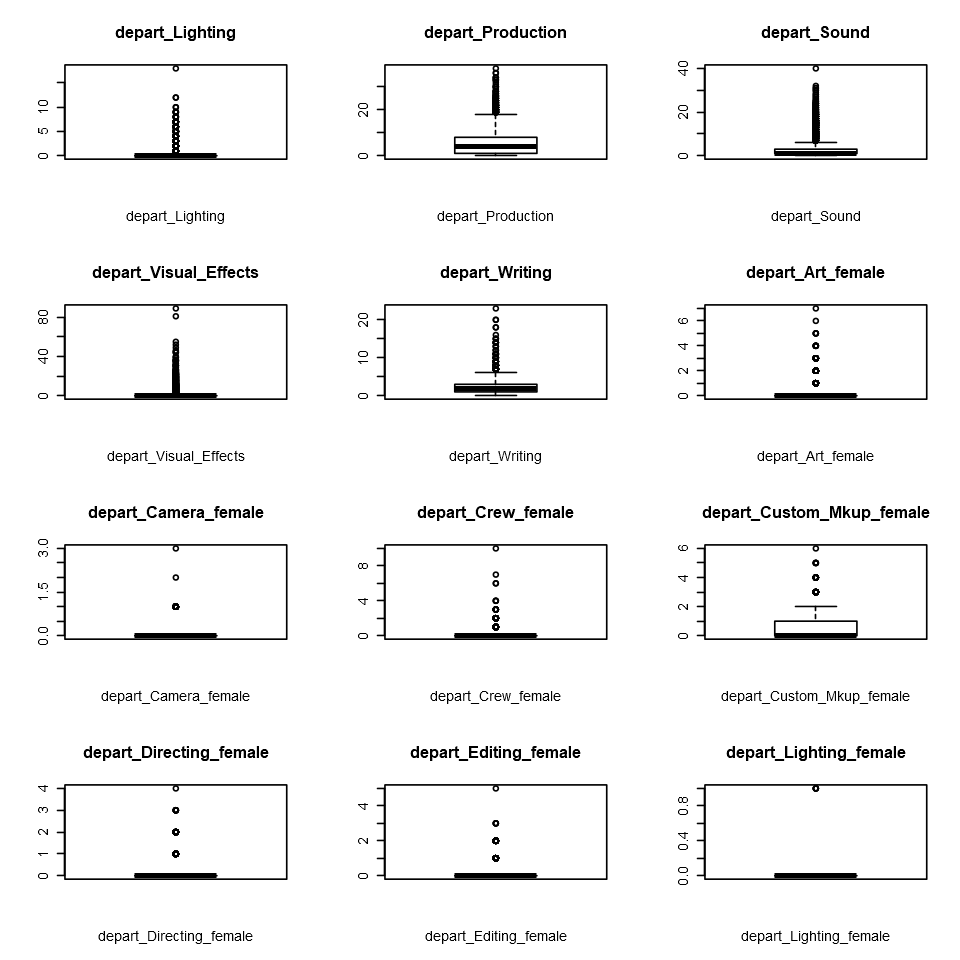

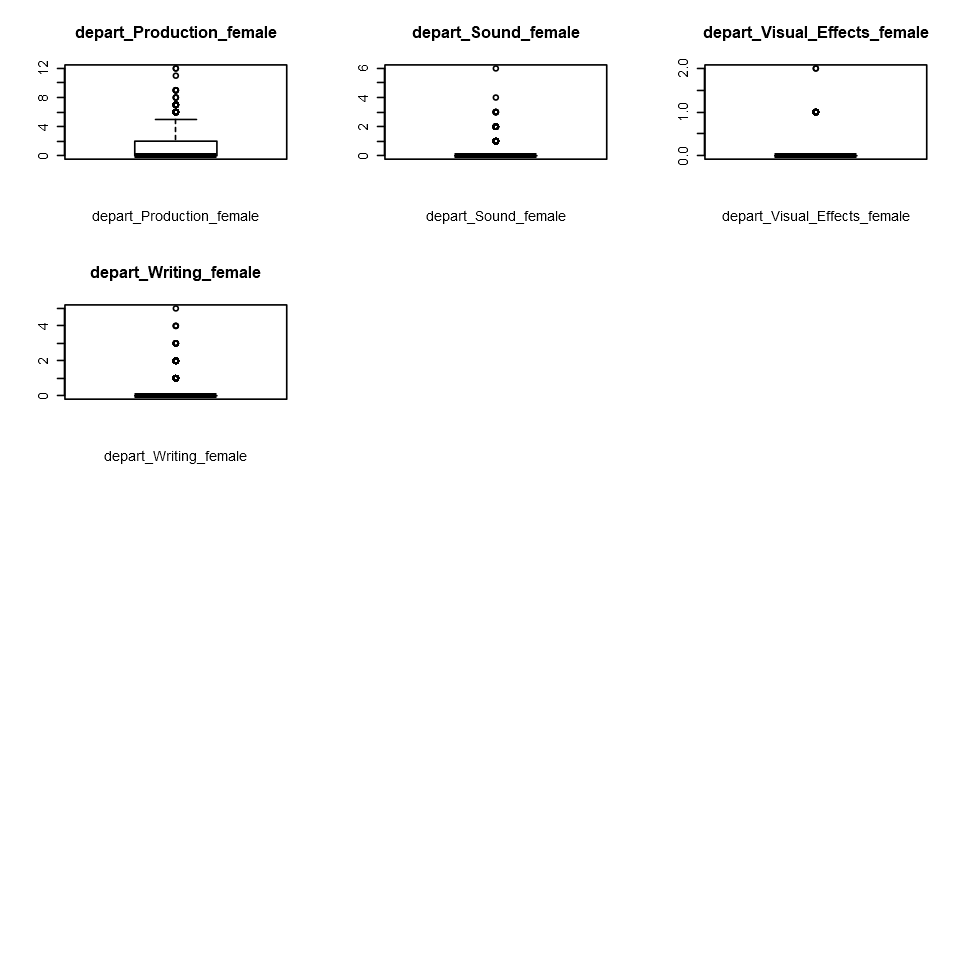

In [72]:

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
nm <- names(BoxOffice[,1:85])
for(i in 10:85){
    x<-BoxOffice[,i]
    boxplot (x,xlab=nm[i],main=nm[i])
    }
nm


In [67]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(BoxOffice[,2:85])) {
    scatter.smooth(BoxOffice[[v]] ~ BoxOffice$species, main=v, xlab="BoxOffice",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))

ERROR: Error in xy.coords(x, y, xlabel, ylabel): 'x' and 'y' lengths differ


In [58]:
movies<- movies_ff %>% 
select( movie_id,revenue,budget,popularity,runtime)

movies
 

movie_id,revenue,budget,popularity,runtime
<int>,<int>,<int>,<dbl>,<dbl>
1,12314651,14000000,6.575393,93
2,95149435,40000000,8.248895,113
3,13092000,3300000,64.299990,105
4,16000000,1200000,3.174936,122
5,3923970,0,1.148070,118
6,3261638,8000000,0.743274,83
7,85446075,14000000,7.286477,92
8,2586511,0,1.949044,84
9,34327391,0,6.902423,100


In [60]:
corr_m <- cor(movies,y=NULL,)
head(corr[, 1:4])


ERROR: Error in head(corr[, 1:4]): object 'corr' not found


In [68]:

miss1 <- TestMCARNormality(data=BoxOffice, , del.lesscases = 1, imputation.number = 10)
summary(miss1)


ERROR: Error in t(yo) %*% yo: requires numeric/complex matrix/vector arguments
